# Pairs Trading

By Valentin PICAVET

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings

## Downloading data

In [6]:
start='2014-01-01'
end='2023-01-01'
name_1='Gold'
name_2='Silver'

gold_data = yf.download('GC=F', start=start, end=end)
silver_data=yf.download('SI=F', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


I transform the time series, I index them. They will start at 1. I do it because it's easier to compare their historical prices

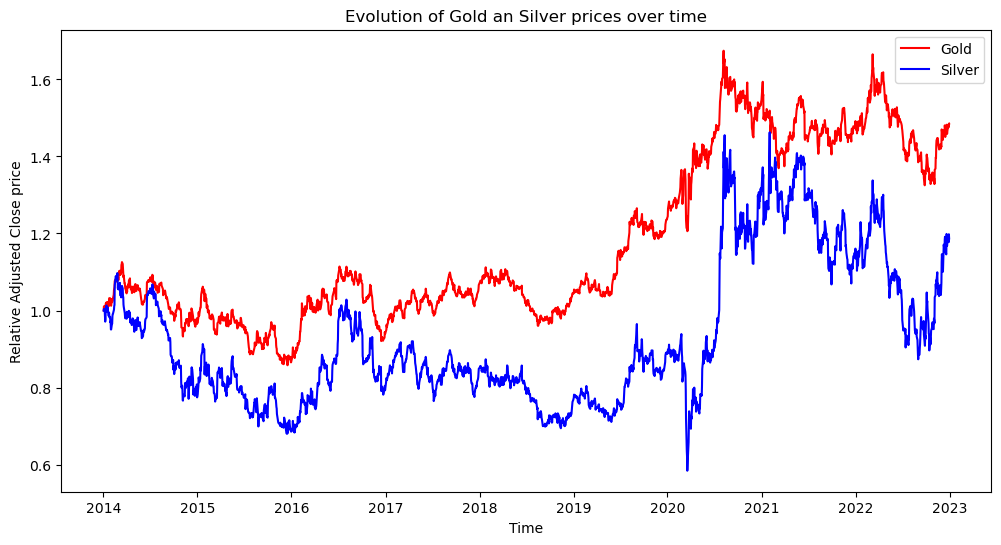

In [7]:
gold_index=gold_data['Adj Close']/gold_data['Adj Close'][0]
silver_index=silver_data['Adj Close']/silver_data['Adj Close'][0]
plt.figure(figsize=(12, 6))
plt.plot(gold_index,color='red',label='Gold')
plt.plot(silver_index,color='blue',label='Silver')
plt.xlabel('Time')
plt.ylabel('Relative Adjusted Close price')
plt.title('Evolution of Gold an Silver prices over time')
plt.legend()
plt.show()

We notice that historical prices have the same trajectory.

## Cointegration

The cointegration test tries to find variables that have a long-run relationship. I'm going to use Engle-Granger paper, that is 2 series variables with l(1) trends, i.e 2 series variables that are integrated order 1 meaning they move upward or downward, could be cointegrated if it could be proved that there is a relationship between the variables. 

First, we create residuals based on the linear regression. Then, we test if the residuals are stationary or not using the Dickey-Fuller test for example.

In [8]:
#Regression

Y=np.log(silver_data['Adj Close'])
X=np.log(gold_data['Adj Close'])
X=sm.add_constant(X)
model=sm.OLS(Y,X)
results=model.fit()
results.params

alpha=results.params.values[0]
beta=results.params.values[1]
error=Y-(alpha+beta*X['Adj Close'])

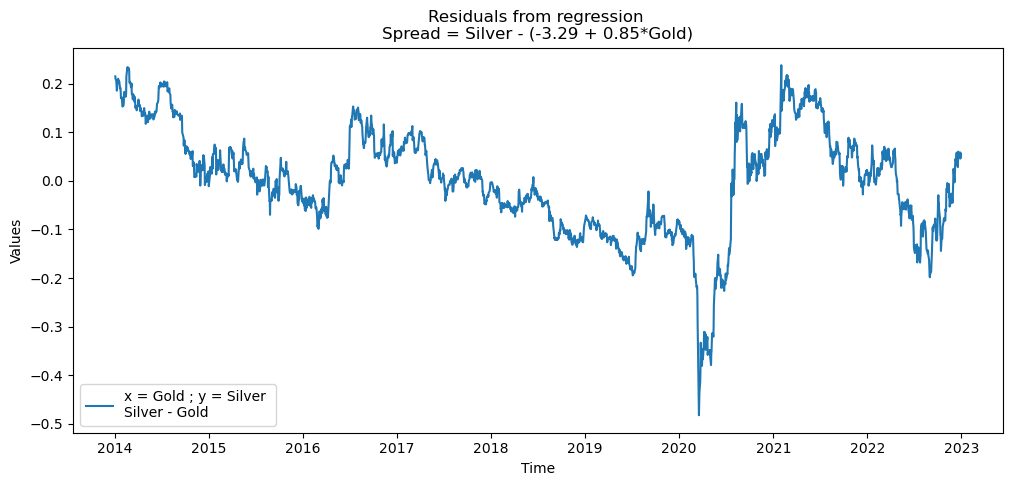

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(error,label=f"x = {name_1} ; y = {name_2} \n{name_2} - {name_1}")
plt.title(f'Residuals from regression \nSpread = {name_2} - ({alpha:.2f} + {beta:.2f}*{name_1})')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

We notice that the error fluctuates around 0.

In [25]:
# Dickey-Fuller test

df_test=adfuller(error,maxlag=1)
df_output=pd.Series(df_test[0:4],index=['Test statistic','p-value',"Number of lags used",'Number of observations used'])
critical_values=pd.Series(df_test[4].values(),index=df_test[4].keys())
print(f'Dickey-Fuller Result: \n{df_output} \n\nDickey-Fuller Critical Values: \n{critical_values}' )

Dickey-Fuller Result: 
Test statistic                   -2.928077
p-value                           0.042179
Number of lags used               1.000000
Number of observations used    2261.000000
dtype: float64 

Dickey-Fuller Critical Values: 
1%    -3.433246
5%    -2.862819
10%   -2.567451
dtype: float64


The Dickey-Fuller p-value is above 1% but below 5% and 10%. Therefore, we reject the existence of integrated time series at 10% and 5% but not at 1%.

## Signals

I'm going to compute z-scores of the spread so to normalize them in order to manipulate them in an easy way.

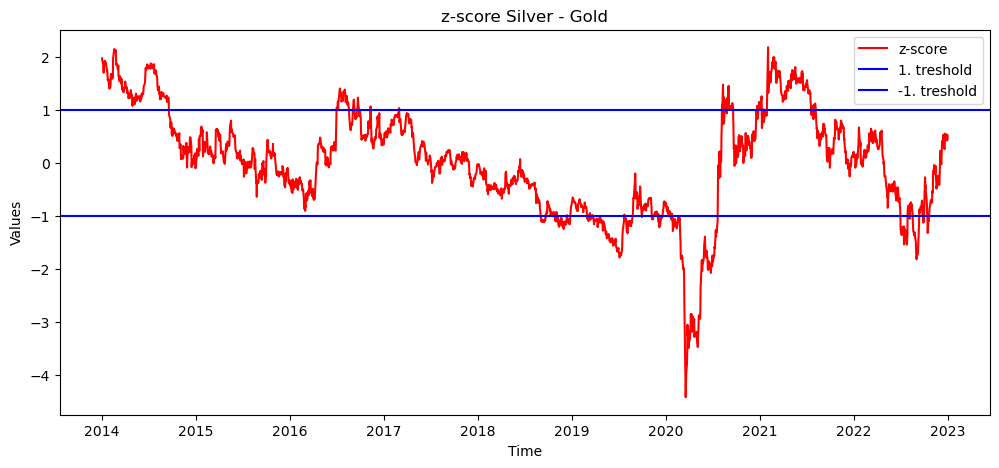

In [30]:
z_score=(error-np.mean(error))/np.std(error)
plt.figure(figsize=(12,5))
plt.plot(z_score,color='red',label='z-score')
plt.title(f'z-score {name_2} - {name_1}')
plt.axhline(y=1.,color='blue',label='1. treshold')
plt.axhline(y=-1.,color='blue',label='-1. treshold')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

We notice that the normalized residuals fluctuate around 0. To identify the moment to implement the strategy, i.e going short/long assets, we need to define treshold to the z-score. In fact, by looking at the graph we can see that every time the z-score is between above 1 or below -1, there is a high probability that the price goes back to 0.

## Strategy

When looking at the spread equation, we have a positive spread when Silver > Gold. I define the strategy as below:
- Long the spread : short position in Silver (winning stock) and a long position in Gold (losing stock) when the z-score crosses 1 from below and there is no position.
- Short the spread : long position in Silver (losing stock) and a short position in Gold (winning stock) when the z-score crosses -1 from above and there is no position.
- Exit position : exit the spread everytime the spread crosses 0 and there is no position. 

In [48]:
signal_entry=1
signal_exit=0

btest=pd.DataFrame()
btest['Silver']=silver_data['Adj Close']
btest['Gold']=gold_data['Adj Close']
btest['Short signal']=(z_score > signal_entry) & (z_score.shift(1) < signal_entry)
btest['Short exit']=(z_score < signal_exit) & (z_score.shift(1) < signal_exit)
btest['Long signal']=(z_score < - signal_entry) & (z_score.shift(1) > -signal_entry)
btest['Long exit']=(z_score > -signal_exit) & (z_score.shift(1) < -signal_exit)

#Back-test
spread_side=None
counter=-1
backtest_result=[]
indicator=0
for time,signals_stock in btest.iterrows():
    counter+=1
    stock_2,stock_1,short_signal,short_exit,long_signal,long_exit=signals_stock
    
    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0 #returns are 0 because no position
        backtest_result.append([time,return_stock2,return_stock1,spread_side])
        
        if short_signal==True:
            spread_side='short'
        elif long_signal==True:
            spread_side='long'
            
    elif spread_side=='long':
        return_stock2=btest['Silver'][counter]/btest['Silver'][counter-1]-1
        return_stock1=btest['Gold'][counter]/btest['Gold'][counter-1]-1
        backtest_result.append([time,return_stock2,-return_stock1,spread_side])
        
        if long_exit==True:
            spread_side=None
    
    elif spread_side=='short':
        return_stock2=btest['Silver'][counter]/btest['Silver'][counter-1]-1
        return_stock1=btest['Gold'][counter]/btest['Gold'][counter-1]-1
        backtest_result.append([time,-return_stock2,return_stock1,spread_side])
        
        if short_exit==True:
            spread_side=None

In [49]:
backtest_df=pd.DataFrame(backtest_result,columns=['Date','Silver','Gold','Side'])
backtest_df['Silver P&L']=np.cumprod(backtest_df['Silver']+1)
backtest_df['Gold P&L']=np.cumprod(backtest_df['Gold']+1)
backtest_df['Total P&L']=(backtest_df['Silver P&L']+backtest_df['Gold P&L'])/2
backtest_df.index=backtest_df['Date']

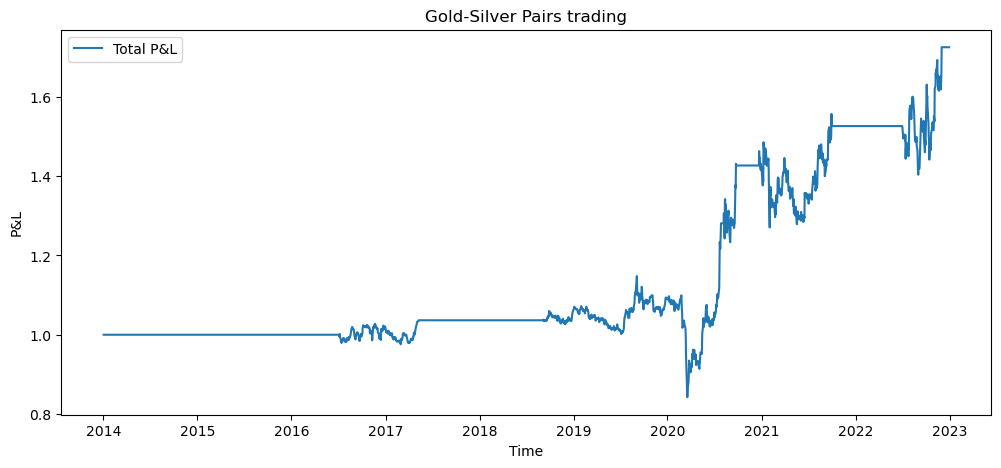

In [50]:
plt.figure(figsize=(12,5))
plt.plot(backtest_df['Total P&L'],label='Total P&L')
plt.title('Gold-Silver Pairs trading')
plt.xlabel('Time')
plt.ylabel('P&L')
plt.legend()
plt.show()